# Import Libraries and Functions

In [1]:
!pip install torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer

import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import torchmetrics
import torchinfo

from torch.utils.data import Dataset, DataLoader

In [3]:
def generate_time_series(n_steps = 120, trend_min = 1.0, trend_max = 5.0, trend_noise_scale = 0.05, alpha = 1., num_cycles = 0, season_noise_scale = 0.):

    trend = np.linspace(trend_min, trend_max, n_steps) + trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    if num_cycles == 0:
        seasonality = 0
    else:
        seasonality = np.sin(np.linspace(0, n_steps, n_steps) * 2 * np.pi / (n_steps / num_cycles)) + season_noise_scale * np.random.randn(n_steps)
        seasonality = seasonality.astype(np.float32)
    total = trend + alpha * seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

In [4]:
def plot_time_series(time_series, n_steps = None):
    fig, ax = plt.subplots(1, 3, figsize = (10, 3))
    if n_steps is None:
        ax[0].plot(time_series["trend"])
        ax[0].set_title("Trend")
        ax[1].plot(time_series["seasonality"])
        ax[1].set_title("Seasonality")
        ax[2].plot(time_series["total"])
        ax[2].set_title("Time Series")
    else:
        ax[0].plot(n_steps, time_series["trend"])
        ax[0].set_title("Trend")
        ax[1].plot(n_steps, time_series["seasonality"])
        ax[1].set_title("Seasonality")
        ax[2].plot(n_steps, time_series["total"])
        ax[2].set_title("Time Series")
    fig.tight_layout()
    plt.show()

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, seq, window = 12, differencing = False, scaler = None):
        self.seq = seq.copy()
        self.window = window
        self.inputs = []
        self.labels = []

        if scaler is not None:
            self.scaler = scaler
            self.seq = (self.scaler.fit_transform(self.seq.reshape(-1, 1))).reshape(-1)
        else:
            self.scaler = None

        if differencing:
            diff = self.seq[1:] - self.seq[: -1]
            for t in range(len(diff) - window):
                input = diff[t: t + window]
                self.inputs.append(input)
                label = diff[t + window]
                self.labels.append(label)
        else:
            for t in range(len(self.seq) - window):
                input = self.seq[t: t + window]
                self.inputs.append(input)
                label = self.seq[t + window]
                self.labels.append(label)

        self.inputs = np.array(self.inputs).reshape(-1, window, 1)
        self.labels = np.array(self.labels).reshape(-1, 1)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.RNN(1, hidden_size = hidden_size, nonlinearity = activation, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, device, hidden_size = 30, activation = "relu"):
        super().__init__()
        self.rnn = nn.LSTM(1, hidden_size = hidden_size, batch_first = True)
        self.linear = nn.Linear(in_features = hidden_size, out_features = 1)

        self.to(device)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x[:, -1, :])
        return x

In [8]:
def train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm):
    epoch_loss = torchmetrics.MeanMetric().to(device)
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        if clip_norm:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss(loss)

    return epoch_loss.compute()

In [9]:
def train_model(model, train_loader, loss_func, optimizer, device, num_epochs = 100, clip_norm = False):
    train_epoch_losses = []
    for epoch in tqdm(range(num_epochs), total=num_epochs, desc='Epochs'):
        train_epoch_loss = train_epoch(model, train_loader, loss_func, optimizer, device, clip_norm)
        train_epoch_losses.append(train_epoch_loss)
        if (epoch +1) % 10 == 0:
            print("Epoch: {}. Train loss: {:.3f}".format(epoch + 1, train_epoch_loss))

    return train_epoch_losses

In [10]:
def forecast(model, input, time_series, device, split, differencing = False, averaging_steps = None, display_seq = False):
    train_step = int(len(time_series['total']) * split)
    forecast_step = len(time_series['total']) - train_step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # last_train = input.__getitem__(-1)[0]
        if differencing:
            last_raw_window = input.seq[-(input.window + 1):]
            last_input_data = last_raw_window[1:] - last_raw_window[:-1] # Calculate diff manually
        else:
            # If no differencing, just take the raw points
            last_input_data = input.seq[-input.window:]

        input_seq = last_input_data.reshape(1, -1, 1)  # Last sequence

        input_tensor = torch.from_numpy(input_seq).to(device)
        preds = []

        for _ in range(forecast_step):
            output = model(input_tensor)
            scaler = input.scaler
            if scaler is not None:
                pred = float((scaler.inverse_transform(output.cpu().numpy()))[0, 0])
            else:
                pred = output.item()
            preds.append(pred)
            input_tensor = torch.cat((input_tensor[:, 1:, :], output.reshape(1, 1, 1)), dim = 1)

    if differencing:
        if averaging_steps is None:
            preds_original = [input.seq[-1].item()]
        else:
            preds_original = [input.seq[-averaging_steps:].mean().item()]
        for pred in preds:
            preds_next = preds_original[-1] + pred
            preds_original.append(preds_next)
        preds = preds_original[1:]
    # Plot the results
    plt.figure(figsize=(10, 6))
    if display_seq:
        print(time_series['total'])
        print(preds)
    plt.plot(range(train_step), time_series['total'][: train_step], label='Train Data', color='blue')
    plt.plot(range(train_step, train_step + forecast_step), time_series['total'][train_step :], label='Test Data', color='green')
    plt.plot(range(train_step, train_step + forecast_step), preds, label='Forecast', color='red')
    plt.legend()
    plt.show()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Perfect Linear Trend

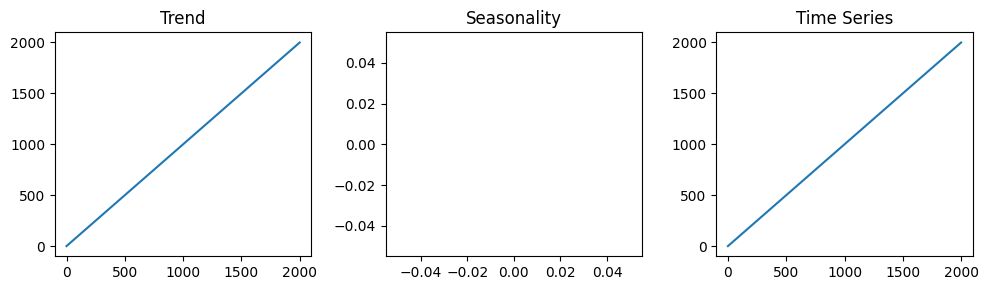

In [267]:
n_steps = 2000
split = 0.5

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1999.0, trend_noise_scale = 0., num_cycles = 0)
plot_time_series(time_series)

## No Differencing

In [272]:
window = 10
scaler = None
differencing = False
split_step = int(n_steps * split)

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [273]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 26662.828
Epoch: 20. Train loss: 0.539
Epoch: 30. Train loss: 0.536
Epoch: 40. Train loss: 0.609
Epoch: 50. Train loss: 0.623
Epoch: 60. Train loss: 0.459
Epoch: 70. Train loss: 0.342
Epoch: 80. Train loss: 0.317
Epoch: 90. Train loss: 0.280
Epoch: 100. Train loss: 0.264


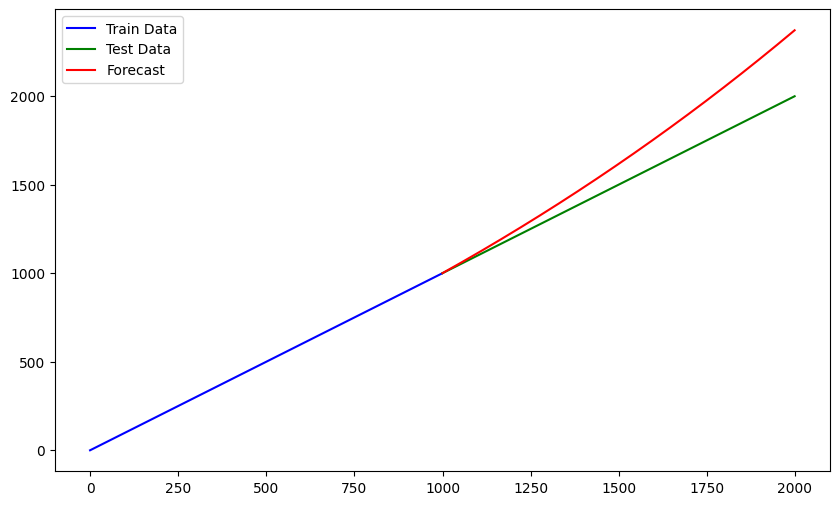

In [274]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

## With Differencing

In [270]:
window = 10
scaler = None
differencing = True
split_step = int(n_steps * split)

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [14]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.153
Epoch: 20. Train loss: 0.038
Epoch: 30. Train loss: 0.006
Epoch: 40. Train loss: 0.001
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


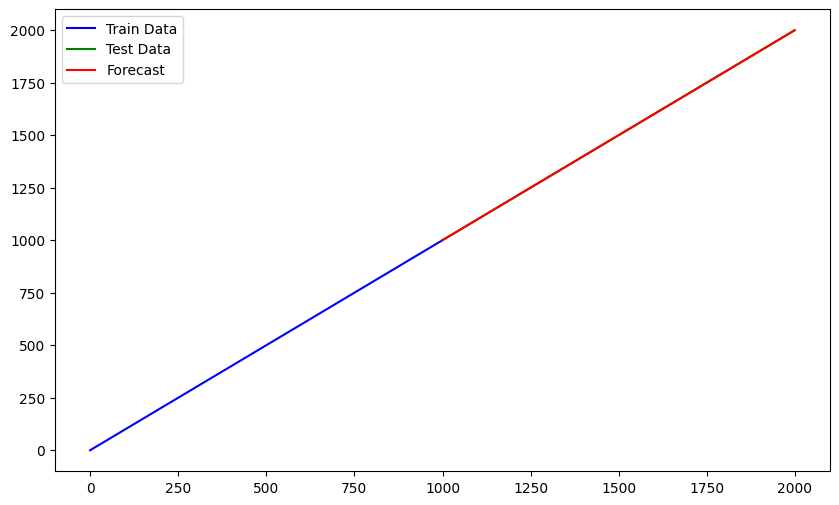

In [15]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Linear Trend with Noise

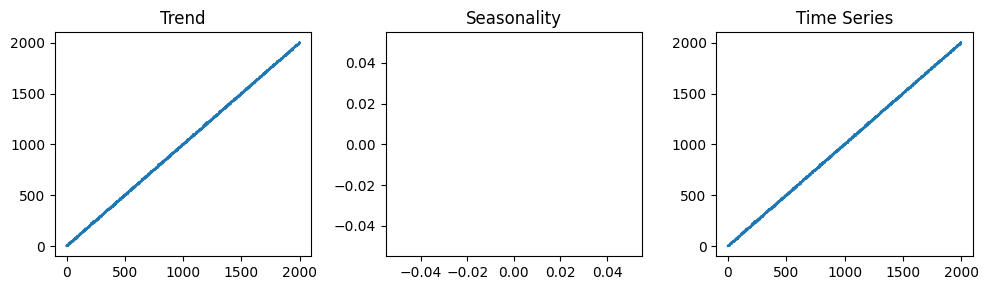

In [16]:
n_steps = 2000
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1999.0, trend_noise_scale = 5.0, num_cycles = 0)
plot_time_series(time_series)

In [17]:
window = 15
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [18]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 32.851
Epoch: 20. Train loss: 28.408
Epoch: 30. Train loss: 27.850
Epoch: 40. Train loss: 27.508
Epoch: 50. Train loss: 27.359
Epoch: 60. Train loss: 27.277
Epoch: 70. Train loss: 27.220
Epoch: 80. Train loss: 27.189
Epoch: 90. Train loss: 27.155
Epoch: 100. Train loss: 27.127


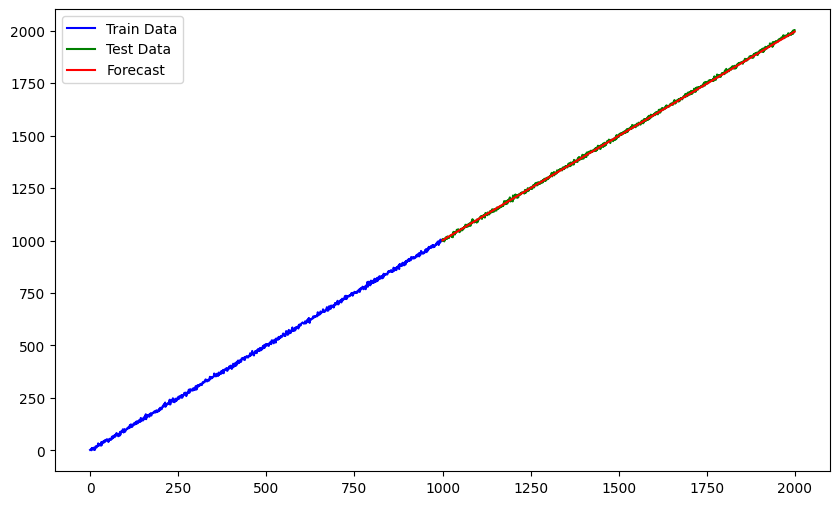

In [19]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Perfect Sine Curve

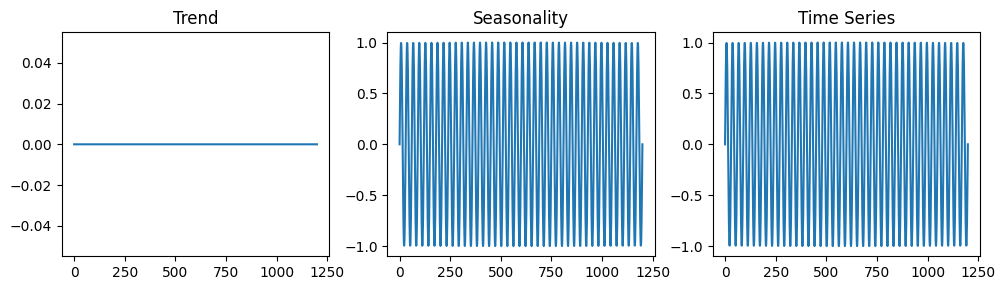

In [100]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 0.0, trend_noise_scale = 0.0, num_cycles = 40)
plot_time_series(time_series)

## No Differencing

In [101]:
window = 30
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [102]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.166
Epoch: 20. Train loss: 0.011
Epoch: 30. Train loss: 0.000
Epoch: 40. Train loss: 0.000
Epoch: 50. Train loss: 0.000
Epoch: 60. Train loss: 0.000
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


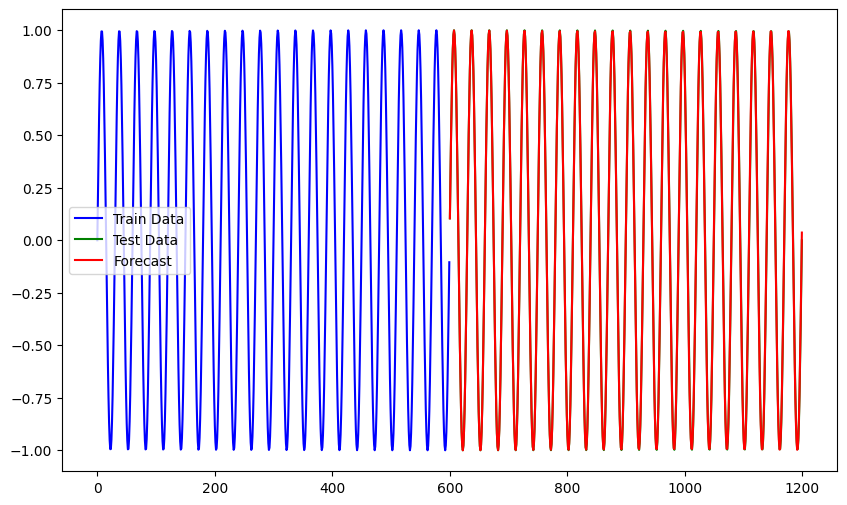

In [103]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

## With Differencing

In [93]:
window = 30
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [94]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.016
Epoch: 20. Train loss: 0.011
Epoch: 30. Train loss: 0.008
Epoch: 40. Train loss: 0.005
Epoch: 50. Train loss: 0.004
Epoch: 60. Train loss: 0.003
Epoch: 70. Train loss: 0.003
Epoch: 80. Train loss: 0.003
Epoch: 90. Train loss: 0.003
Epoch: 100. Train loss: 0.002


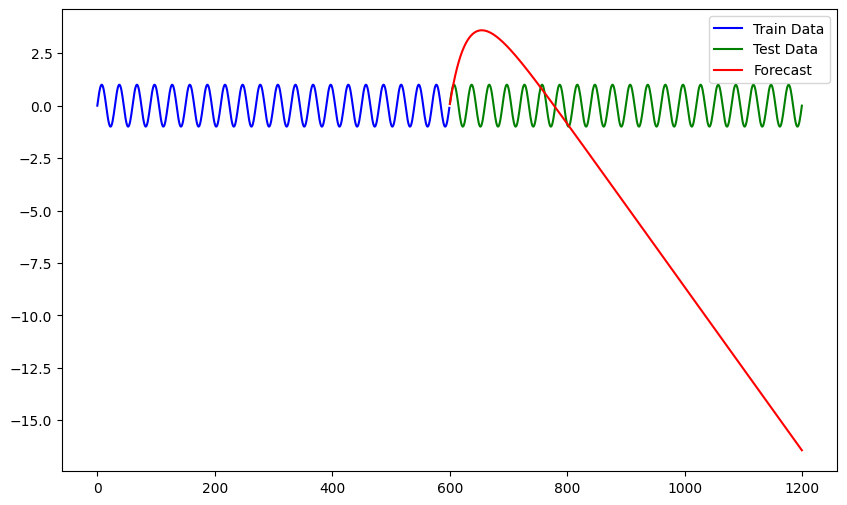

In [95]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Sine Curve with Noise

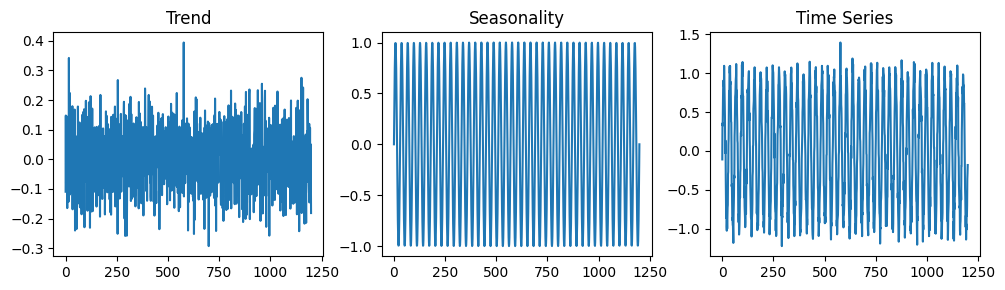

In [105]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 0.0, trend_noise_scale = 0.1, num_cycles = 40)
plot_time_series(time_series)

In [106]:
window = 30
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [107]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.159
Epoch: 20. Train loss: 0.014
Epoch: 30. Train loss: 0.013
Epoch: 40. Train loss: 0.013
Epoch: 50. Train loss: 0.013
Epoch: 60. Train loss: 0.013
Epoch: 70. Train loss: 0.012
Epoch: 80. Train loss: 0.012
Epoch: 90. Train loss: 0.012
Epoch: 100. Train loss: 0.012


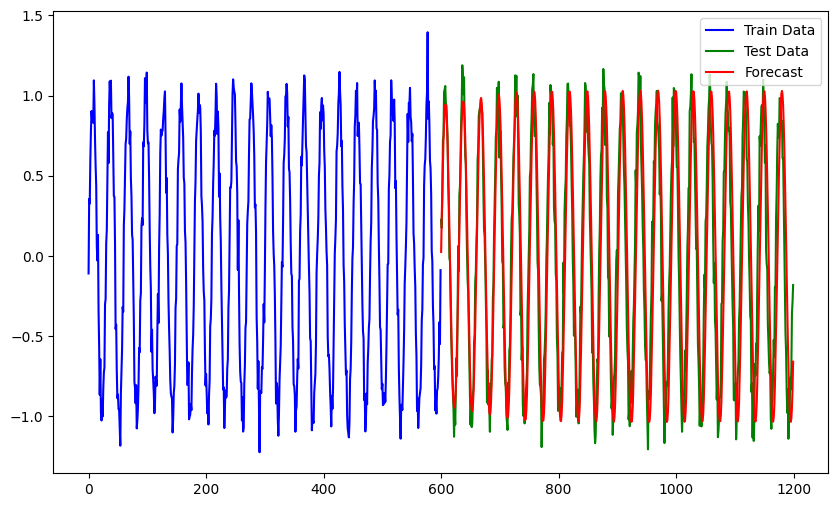

In [108]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Perfect Sine Curve with Linear Trend

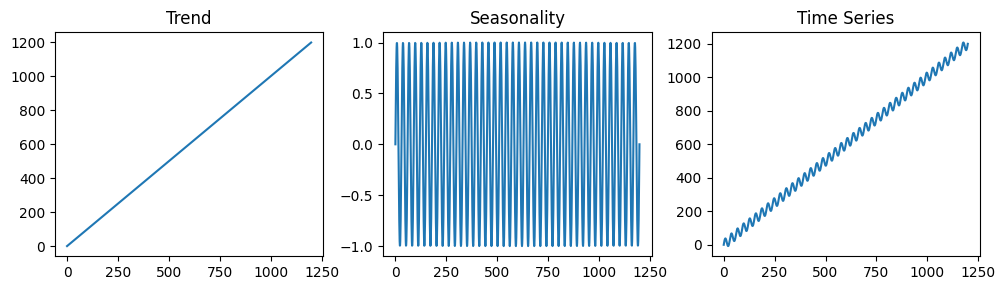

In [144]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1199.0, trend_noise_scale = 0., alpha = 30., num_cycles = 40)
plot_time_series(time_series)

In [145]:
window = 30
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [148]:
model = SimpleRNN(device = device, hidden_size = 6, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 5.204
Epoch: 20. Train loss: 1.271
Epoch: 30. Train loss: 0.113
Epoch: 40. Train loss: 0.020
Epoch: 50. Train loss: 0.004
Epoch: 60. Train loss: 0.001
Epoch: 70. Train loss: 0.000
Epoch: 80. Train loss: 0.000
Epoch: 90. Train loss: 0.000
Epoch: 100. Train loss: 0.000


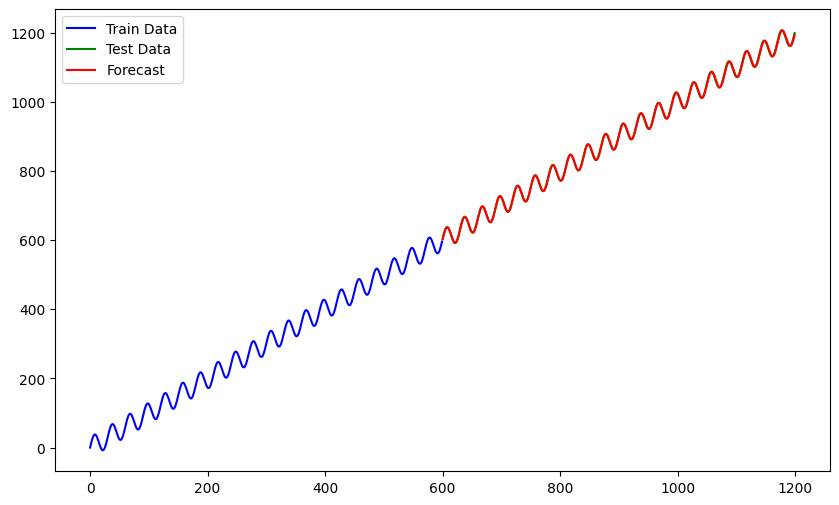

In [149]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Sine Curve with Linear Trend and Noise

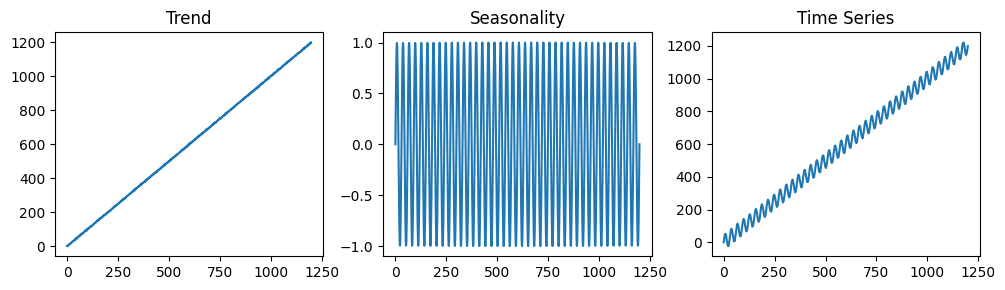

In [185]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = generate_time_series(n_steps = n_steps, trend_min = 0.0, trend_max = 1199.0, trend_noise_scale = 1.5, alpha = 45., num_cycles = 40)
plot_time_series(time_series)

In [189]:
window = 45
scaler = None
differencing = True

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [190]:
model = SimpleRNN(device = device, hidden_size = 12, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, num_epochs = 150, clip_norm = False)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 10. Train loss: 7.718
Epoch: 20. Train loss: 6.544
Epoch: 30. Train loss: 5.244
Epoch: 40. Train loss: 4.618
Epoch: 50. Train loss: 4.167
Epoch: 60. Train loss: 3.882
Epoch: 70. Train loss: 3.661
Epoch: 80. Train loss: 3.522
Epoch: 90. Train loss: 3.389
Epoch: 100. Train loss: 3.330
Epoch: 110. Train loss: 3.261
Epoch: 120. Train loss: 3.259
Epoch: 130. Train loss: 3.175
Epoch: 140. Train loss: 3.165
Epoch: 150. Train loss: 3.114


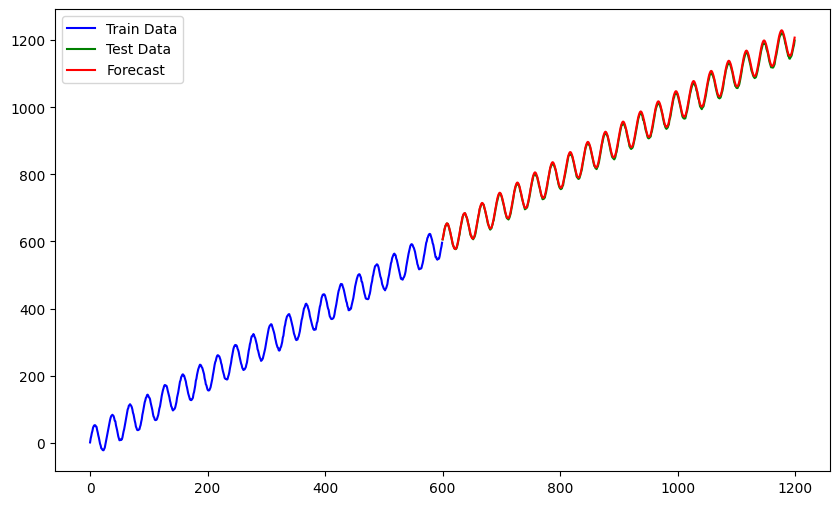

In [191]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

# Other Time Series

## Damped Time Series

In [275]:
def damped_time_series(start = 0, end = 10, n_steps = 120, trend_noise_scale = 0.0, alpha = 1., ):

    trend = trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    time_steps = np.linspace(start, end, n_steps)
    seasonality = np.exp(-0.1 * time_steps) * np.cos(4 * np.pi * time_steps)
    seasonality = seasonality.astype(np.float32)
    total = trend + alpha * seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

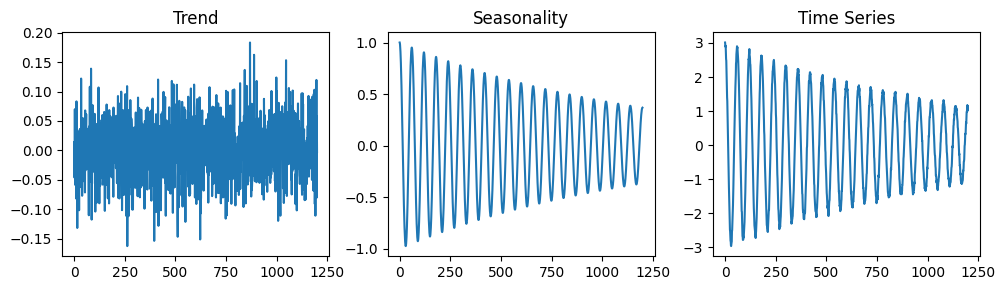

In [276]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = damped_time_series(n_steps = n_steps, trend_noise_scale = 0.05, alpha = 3., )
plot_time_series(time_series)

In [277]:
window = 30
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [278]:
model = SimpleRNN(device = device, hidden_size = 12, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.143
Epoch: 20. Train loss: 0.054
Epoch: 30. Train loss: 0.028
Epoch: 40. Train loss: 0.008
Epoch: 50. Train loss: 0.005
Epoch: 60. Train loss: 0.004
Epoch: 70. Train loss: 0.004
Epoch: 80. Train loss: 0.004
Epoch: 90. Train loss: 0.004
Epoch: 100. Train loss: 0.004


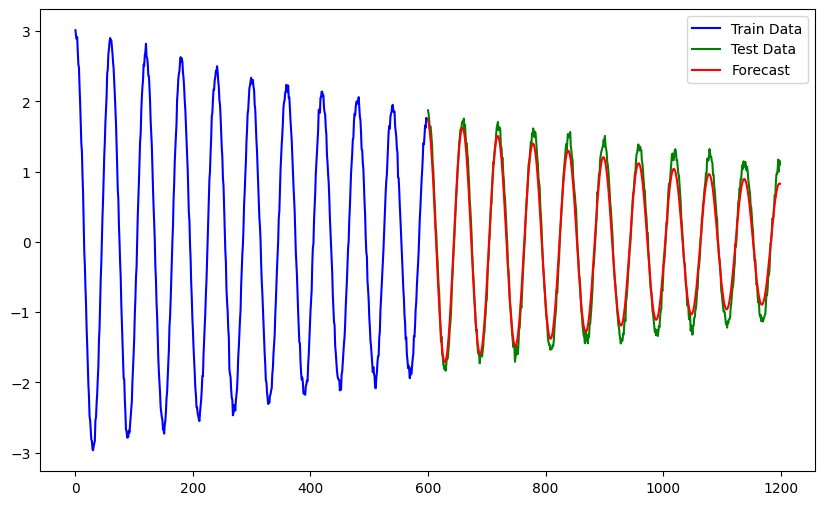

In [279]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)

## Dual Cycle-Time Series

In [219]:
def dual_cycle_time_series(n_steps = 500, period_1 = 50, period_2 = 10, trend_noise_scale = 0.1, alpha = 1.0):
    """
    Generates a time series with two distinct cyclical patterns superimposed.

    Args:
        n_steps (int): Total number of time steps.
        period1 (int): The length of the slow cycle (e.g., yearly).
        period2 (int): The length of the fast cycle (e.g., weekly).
        noise_scale (float): Magnitude of random noise.
    """
    t = np.arange(n_steps)

    trend = trend_noise_scale * np.random.randn(n_steps)
    trend = trend.astype(np.float32)
    # 1. Slow Cycle
    cycle_slow = np.sin(t * 2 * np.pi / period_1)

    # 2. Fast Cycle
    cycle_fast = np.sin(t * 2 * np.pi / period_2)

    seasonality = (cycle_slow + 0.5 * cycle_fast).astype(np.float32)

    # 3. Combine them
    # We can scale them differently (e.g., slow cycle is stronger)
    total = trend + alpha * seasonality

    return {"trend": trend, "seasonality": seasonality, "total": total}

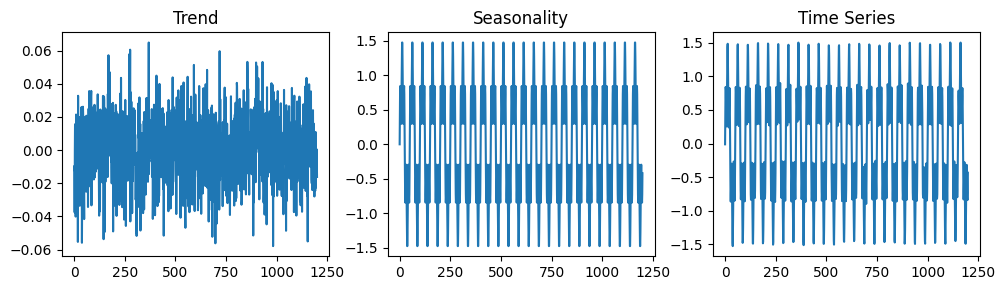

In [226]:
n_steps = 1200
split = 0.5
split_step = int(n_steps * split)

time_series = dual_cycle_time_series(n_steps = n_steps, trend_noise_scale = 0.02)
plot_time_series(time_series)

In [227]:
window = 45
scaler = None
differencing = False

train_dataset = TimeSeriesDataset(time_series['total'][: split_step], window = window, differencing = differencing, scaler = scaler)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)

In [228]:
model = SimpleRNN(device = device, hidden_size = 12, activation = "relu")
loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
train_epoch_losses = train_model(model, train_loader, loss_func, optimizer, device, clip_norm = False)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10. Train loss: 0.138
Epoch: 20. Train loss: 0.053
Epoch: 30. Train loss: 0.031
Epoch: 40. Train loss: 0.013
Epoch: 50. Train loss: 0.006
Epoch: 60. Train loss: 0.004
Epoch: 70. Train loss: 0.004
Epoch: 80. Train loss: 0.004
Epoch: 90. Train loss: 0.003
Epoch: 100. Train loss: 0.003


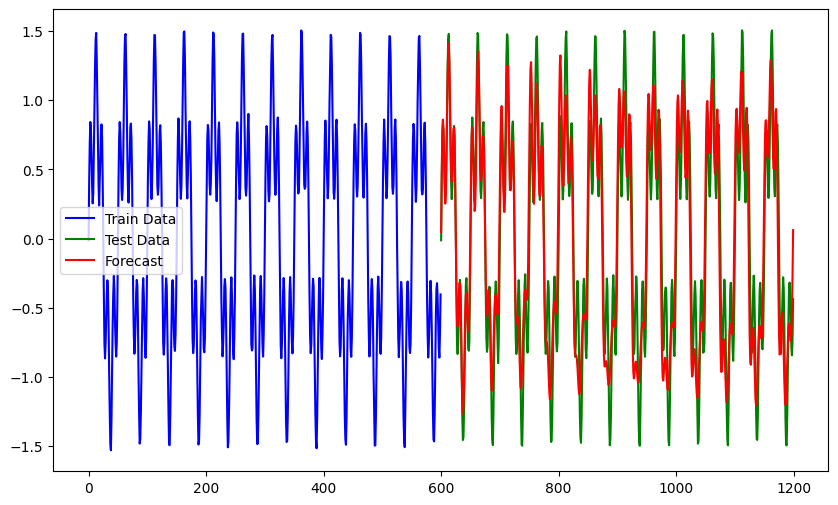

In [229]:
forecast(model, train_dataset, time_series, device = device, split = split, differencing = differencing)